In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from collections import Counter
import src.kgbench as kg


from kgbench import load, tic, toc, d
from matplotlib.font_manager import FontProperties

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from src.rgcn_explainer_utils import *
from IPython.core.interactiveshell import InteractiveShell
from rgcn import RGCN

import stat
import numpy as np
from scipy.stats import chi2_contingency

/usr/local/Caskroom/miniconda/base/envs/RGCNExplainer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


In [36]:
from src.rgcn_explainer_utils import *
name = 'mdgenre'
if name in ['aifb', 'mutag', 'mdgenre', 'amplus', 'dmg777k', 'mdgender']:
    data = kg.load(name, torch=True, final=False)
if 'IMDb' in name:    
    data = torch.load(f'data/IMDB/finals/{name}.pt')
if 'dbo' in name:
    data = torch.load(f'data/DBO/finals/{name}.pt')
data.triples = torch.Tensor(data.triples).to(int)
data.withheld = torch.Tensor(data.withheld).to(int)
data.training = torch.Tensor(data.training).to(int)
relations = get_relations(data)
dict_classes = d_classes(data)

print('rel:', data.num_relations, 'ent:', data.num_entities, 'triples:', data.triples.shape)
print('training', data.training.shape, 'withheld', data.withheld.shape)
if name == 'aifb' :#or name == 'dbo_gender':
    sample = False

else:
    sample=True

loaded data mdgenre (69.31s).
rel: 154 ent: 349344 triples: torch.Size([1252247, 3])
training torch.Size([4863, 2]) withheld torch.Size([500, 2])


TABLES WITH RESULTS FOR DIFFERENT MASK INITIALIZATIONS

In [11]:
def metrics(path, per_class = False, sample = True):
    if sample:
        sample= 'sample'
    else:
        sample = 'full'
    df = pd.read_csv(path+f'/Relations_Important_{sample}_threshold.csv', index_col = 'label')
    result_df = pd.DataFrame()
    if per_class:
        group = df.groupby('label').mean()
        result_df['label'] = group.index
    else:
        columns = ['sparsity_threshold','fidelity_minus_threshold','fidelity_plus_threshold','fidelity_minus_random','fidelity_plus_random']
        group = df[columns].mean()
    
    score = np.round(group['sparsity_threshold'],3) + np.round(group['fidelity_minus_threshold'],3) + np.round(group['fidelity_plus_threshold'],3)
    sparsity = np.round(group['sparsity_threshold'],3)
    fidelity_minus = np.round(group['fidelity_minus_threshold'],3)
    fidelity_plus = np.round(group['fidelity_plus_threshold'],3)
    fidelity_minus_random = np.round(group['fidelity_minus_random'],3)
    fidelity_plus_random = np.round(group['fidelity_plus_random'],3)
    if per_class:
        result_df['Score'] = score
        result_df['Sparsity'] = sparsity
        result_df['Fidelity-'] = fidelity_minus
        result_df['Fidelity+'] = fidelity_plus
        result_df['Fidelity- random'] = fidelity_minus_random
        result_df['Fidelity+ random'] = fidelity_plus_random


        table = result_df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
        latex_table = table.replace('\\midrule', '\\hline')
        latex_table = latex_table.replace('\\toprule', '\\hline')
        latex_table = latex_table.replace('\\bottomrule', '\\hline')
        latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
        latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
        print(latex_table)
    else: 
        return score, sparsity, fidelity_minus, fidelity_plus, fidelity_minus_random, fidelity_plus_random


def table_metrics_overview(name, params, old=False ,sample=True):
    '''Overview of the metrics for the different initializations
    name: name of the dataset
    params: parameters of the experiment (after init)'''
    init = ['normal','overall_frequency','relative_frequency','inverse_relative_frequency','domain_frequency','range_frequency']
    if name == 'aifb':
        init += ['Domain_Knowledge_forward','Domain_Knowledge_backward']
    df = pd.DataFrame(columns = ['init','Score','Sparsity', 'Fidelity-', 'Fidelity+', 'Fidelity- random', 'Fidelity+ random'])
    for i in init:
        if old:
            m = metrics(f'chk/{name}_chk/bro/exp/init_{i}_{params}/Relation_Importance',per_class = False,sample=sample)
        else:
            m = metrics(f'chk/{name}_chk/exp/init_{i}_{params}/Relation_Importance',per_class=False,sample=sample)
        df.loc[len(df)] = [i] + list(m)
    df.set_index('init', inplace=True)
    table = df.to_latex(index=True, caption = name, label = name,column_format='|c|c|c|c|c|c|c|')
    latex_table = table.replace('\\midrule', '\\hline')
    latex_table = latex_table.replace('\\toprule', '\\hline')
    latex_table = latex_table.replace('\\bottomrule', '\\hline')
    latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
    latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
    print(latex_table)
    return latex_table


table_metrics_overview(name,'lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1', sample=sample )
#table_metrics_overview(name, 'hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no',old=True)

\begin{table}
\centering
\caption{dbo_gender}
\label{dbo_gender}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
{} &  Score &  Sparsity &  Fidelity- &  Fidelity+ &  Fidelity- random &  Fidelity+ random \\
init                       &        &           &            &            &                   &                   \\
\hline
normal                     &  2.091 &     0.731 &       0.94 &       0.42 &              0.68 &              0.16 \\
overall\_frequency          &  2.103 &     0.683 &       1.00 &       0.42 &              0.82 &              0.16 \\
relative\_frequency         &  2.077 &     0.677 &       0.98 &       0.42 &              0.80 &              0.12 \\
inverse\_relative\_frequency &  2.104 &     0.684 &       1.00 &       0.42 &              0.84 &              0.16 \\
domain\_frequency           &  2.104 &     0.684 &       1.00 &       0.42 &              0.82 &              0.16 \\
range\_frequency            &  2.106 &     0.686 &       1.0

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62368/1438229792.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df.to_latex(index=True, caption = name, label = name,column_format='|c|c|c|c|c|c|c|')


'\\begin{table}\n\\centering\n\\caption{dbo_gender}\n\\label{dbo_gender}\n\\begin{adjustbox}{scale=0.5}\\begin{tabular}{|c|c|c|c|c|c|c|}\n\\hline\n{} &  Score &  Sparsity &  Fidelity- &  Fidelity+ &  Fidelity- random &  Fidelity+ random \\\\\ninit                       &        &           &            &            &                   &                   \\\\\n\\hline\nnormal                     &  2.091 &     0.731 &       0.94 &       0.42 &              0.68 &              0.16 \\\\\noverall\\_frequency          &  2.103 &     0.683 &       1.00 &       0.42 &              0.82 &              0.16 \\\\\nrelative\\_frequency         &  2.077 &     0.677 &       0.98 &       0.42 &              0.80 &              0.12 \\\\\ninverse\\_relative\\_frequency &  2.104 &     0.684 &       1.00 &       0.42 &              0.84 &              0.16 \\\\\ndomain\\_frequency           &  2.104 &     0.684 &       1.00 &       0.42 &              0.82 &              0.16 \\\\\nrange\\_frequency 

In [48]:
sample

True

In [38]:
#for just one node
def metrics_one_node(path, node_idx ):

    df = pd.read_csv(path+f'/Relations_Important_{node_idx}_threshold.csv', index_col = 'label')
    result_df = pd.DataFrame()


    columns = ['score_threshold_prob','sparsity_threshold','fidelity_minus_threshold','fidelity_plus_threshold','fidelity_minus_random','fidelity_plus_random']
    group = df[columns].mean()
    
    score = np.round(group['sparsity_threshold'],5) + np.round(group['fidelity_minus_threshold'],3) + np.round(group['fidelity_plus_threshold'],3)
    sparsity = np.round(group['sparsity_threshold'],5)
    fidelity_minus = np.round(group['fidelity_minus_threshold'],5)
    fidelity_plus = np.round(group['fidelity_plus_threshold'],5)
    fidelity_minus_random = np.round(group['fidelity_minus_random'],5)
    fidelity_plus_random = np.round(group['fidelity_plus_random'],5)
    score_threshold_prob = np.round(group['score_threshold_prob'],5)
    return score,score_threshold_prob, sparsity, fidelity_minus, fidelity_plus, fidelity_minus_random, fidelity_plus_random


def table_metrics_overview_one_node(name, params, node_idx):
    '''Overview of the metrics for the different initializations
    name: name of the dataset
    params: parameters of the experiment (after init)'''
    init = ['normal','overall_frequency','relative_frequency','inverse_relative_frequency','domain_frequency','range_frequency']#,'Domain_Knowledge_forward','Domain_Knowledge_backward']
    df = pd.DataFrame(columns = ['init','Score', 'Score Prob','Sparsity', 'Fidelity-', 'Fidelity+', 'Fidelity- random', 'Fidelity+ random'])
    for i in init:

        m = metrics_one_node(f'chk/{name}_chk/exp/init_{i}_{params}/Relation_Importance', node_idx)
        df.loc[len(df)] = [i] + list(m)
    df.set_index('init', inplace=True)
    table = df.to_latex(index=True, caption = name, label = name,column_format='|c|c|c|c|c|c|c|')
    latex_table = table.replace('\\midrule', '\\hline')
    latex_table = latex_table.replace('\\toprule', '\\hline')
    latex_table = latex_table.replace('\\bottomrule', '\\hline')
    latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
    latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
    #print(latex_table)
    return latex_table

if name == 'amplus':
    node_idx = 998478
elif name == 'mdgenre':
    node_idx = 243773
latex_table = table_metrics_overview_one_node(name,'lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1', node_idx) 
print(latex_table)

\begin{table}
\centering
\caption{mdgenre}
\label{mdgenre}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
{} &    Score &  Score Prob &  Sparsity &  Fidelity- &  Fidelity+ &  Fidelity- random &  Fidelity+ random \\
init                       &          &             &           &            &            &                   &                   \\
\hline
normal                     &  2.99873 &     1.99643 &   0.99873 &        1.0 &        1.0 &               0.0 &               0.0 \\
overall\_frequency          &  1.98608 &     1.98608 &   0.98608 &        0.0 &        1.0 &               1.0 &               0.0 \\
relative\_frequency         &  1.98608 &     1.98608 &   0.98608 &        0.0 &        1.0 &               1.0 &               0.0 \\
inverse\_relative\_frequency &  1.98608 &     1.98608 &   0.98608 &        0.0 &        1.0 &               1.0 &               0.0 \\
domain\_frequency           &  1.98608 &     1.98608 &   0.98608 &        0.0 &        1

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62368/2550839807.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df.to_latex(index=True, caption = name, label = name,column_format='|c|c|c|c|c|c|c|')


In [58]:
inits =  ['normal', 'overall_frequency', 'relative_frequency', 'inverse_relative_frequency', 'domain_frequency', 'range_frequency']
for init in inits:
    path = f'chk/{name}_chk/exp/init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/Relation_Importance/'
    result_df = metrics(path, per_class = True)
    print(result_df)

\begin{table}
\centering
\caption{Relation-Importance}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &  label &  Score &  Sparsity &  Fidelity- &  Fidelity+ &  Fidelity- random &  Fidelity+ random \\
\hline
0 &      0 &  1.986 &     0.986 &      1.000 &        0.0 &             1.000 &             0.000 \\
1 &      1 &  2.983 &     0.983 &      1.000 &        1.0 &             0.250 &             0.000 \\
2 &      2 &  2.972 &     0.972 &      1.000 &        1.0 &             0.455 &             0.091 \\
3 &      3 &  2.731 &     0.898 &      0.833 &        1.0 &             0.000 &             0.167 \\
\hline
\end{tabular}\end{adjustbox}
\end{table}

None
\begin{table}
\centering
\caption{Relation-Importance}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &  label &  Score &  Sparsity &  Fidelity- &  Fidelity+ &  Fidelity- random &  Fidelity+ ran

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_23470/115827712.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = result_df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_23470/115827712.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = result_df.to_latex(index=True, 

In [60]:
init = 'normal'
path = f'chk/{name}_chk/exp/init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/Relation_Importance/'
result_df = metrics(path, per_class = True)
print(result_df)

\begin{table}
\centering
\caption{Relation-Importance}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &  label &  Score &  Sparsity &  Fidelity- &  Fidelity+ &  Fidelity- random &  Fidelity+ random \\
\hline
0 &      0 &  1.986 &     0.986 &      1.000 &        0.0 &             1.000 &             0.000 \\
1 &      1 &  2.983 &     0.983 &      1.000 &        1.0 &             0.250 &             0.000 \\
2 &      2 &  2.972 &     0.972 &      1.000 &        1.0 &             0.455 &             0.091 \\
3 &      3 &  2.731 &     0.898 &      0.833 &        1.0 &             0.000 &             0.167 \\
\hline
\end{tabular}\end{adjustbox}
\end{table}

None


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_23470/115827712.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = result_df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


RELATION DISTRIBUTION

In [7]:
#SRC

def keep_columns_with_non_zero_values(df):
    ''' Keep only columns with non-zero values'''

    df = df.fillna(0)
    # Get the column names with non-zero values
    non_zero_columns = df.columns[df.astype(bool).any(axis=0)]

    # Create a new DataFrame with only the columns containing non-zero values
    modified_df = df[non_zero_columns]

    return modified_df

def modified_counter(path,relations):
    df = pd.read_csv(path, index_col = 'label')[relations]
    df = keep_columns_with_non_zero_values(df)
    mean_df = df.groupby('label').mean()
    return mean_df   


def bar_plot(full, explain):
    ''' Create a bar plot (histograms with adjacent bars) for the full graph and the explanation subgraph'''
    full_graph_df = pd.DataFrame(list(full.items()), columns=['Relation Name', 'Count'])
    explanation_df = pd.DataFrame(list(explain.items()), columns=['Relation Name', 'Count'])

    # Merge the DataFrames and calculate the total counts
    merged_df = pd.merge(full_graph_df, explanation_df, on='Relation Name', how='outer', suffixes=('_full', '_explanation'))
    merged_df = merged_df.fillna(0)
    total_full_graph = merged_df['Count_full'].sum()
    total_explanation = merged_df['Count_explanation'].sum()

    # Calculate the percentages for each relation in both full graph and explanation subgraph
    merged_df['Percentage_full'] = merged_df['Count_full'] / total_full_graph * 100
    merged_df['Percentage_explanation'] = merged_df['Count_explanation'] / total_explanation * 100

    # Sort the DataFrame by the counts in descending order
    sorted_df = merged_df.sort_values(by='Count_full', ascending=False)

    # Create the bar plot (histograms with adjacent bars)
    bar_width = 0.4
    bar_positions_full_graph = np.arange(len(sorted_df))
    bar_positions_explanation = bar_positions_full_graph + bar_width
    return bar_positions_full_graph, bar_positions_explanation, sorted_df, bar_width

def bar_plot_and_plot(data,init, relations, sample = False):
    ''' Plot the distribution of relations per class for the full graph and the explanation subgraph'''
    #exp = f'init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1'

    path = f'chk/{data.name}_chk/exp/init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/Relation_Importance/'
    if sample:
        explain = modified_counter(path+'/Relations_Important_sample_threshold.csv',relations)
    else:
        explain = modified_counter(path+'/Relations_Important_full_threshold.csv',relations)    
    full = modified_counter(path+'/Relations_Important_full_neighborhood.csv',relations)

    # Calculate the number of rows and columns for subplots based on data.num_classes
    num_classes = data.num_classes
    num_rows = min(int(np.ceil(num_classes / 2)), 2)
    num_cols = min(num_classes, 2)

    # Create the figure and axes
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))

    # Iterate through the labels and plot the data
    for label, ax in zip(range(num_classes), axes.flat):
        full_dict = full.loc[label].to_dict()
        explain_dict = explain.loc[label].to_dict()
        bar_positions_full_graph, bar_positions_explanation, sorted_df, bar_width = bar_plot(full_dict, explain_dict)

        ax.bar(bar_positions_full_graph, sorted_df['Percentage_full'], width=bar_width, alpha=0.7, color='blue', edgecolor='black', label='Full Graph')
        ax.bar(bar_positions_explanation, sorted_df['Percentage_explanation'], width=bar_width, alpha=0.7, color='green', edgecolor='black', label='Explanation Subgraph')
        ax.set_xticks(bar_positions_full_graph + bar_width / 2)
        ax.set_xticklabels(sorted_df['Relation Name'], rotation=75)
        ax.set_ylabel('Relative Frequency (%)')
        ax.set_title(f'Distribution of Relations per class {label}')
        ax.legend(loc='upper right')

    # Adjust the layout and spacing
    plt.tight_layout()
    plt.suptitle(f'Relation distribution {data.name} ', fontsize=16, y=0.95,fontproperties=FontProperties(weight='bold'))
    plt.subplots_adjust(top=0.85) 

    # Show the plots
    plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11,) and arg 1 with shape (14,).

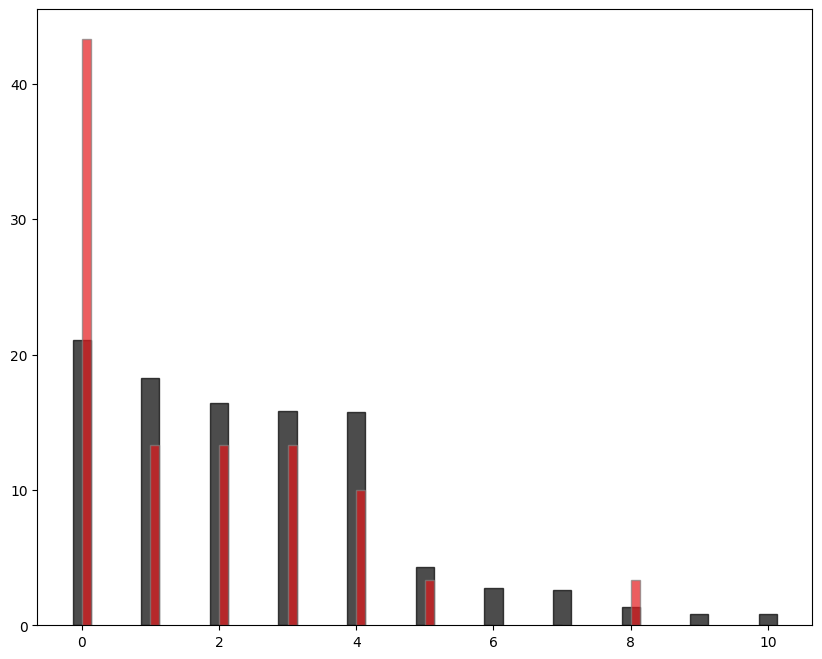

In [314]:


def bar_plot_and_plot2(data, relations, class_to_plot = None, sample=False):

    def path_get(init):
        path = f'chk/{data.name}_chk/exp/init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/Relation_Importance/'
        return path

    full = modified_counter(path_get('normal')+'/Relations_Important_full_neighborhood.csv', relations)

    if sample:
        sample = 'sample'
    else:
        sample = 'full'

    # Explanation methods
    explanation_methods = ['normal', 'overall_frequency', 'relative_frequency', 'inverse_relative_frequency', 'domain_frequency', 'range_frequency']
    if data.name == 'aifb':
        explanation_methods = ['normal', 'overall_frequency', 'relative_frequency', 'inverse_relative_frequency', 'domain_frequency', 'range_frequency', 'Domain_Knowledge_forward', 'Domain_Knowledge_backward']

    
    colormap = plt.cm.Set1.colors 


    # Calculate the number of rows and columns for subplots based on data.num_classes
    num_classes = data.num_classes
    num_rows = min(int(np.ceil(num_classes / 2)), 2)
    num_cols = min(num_classes, 2)

    # # Create the figure and axes
    # fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))
    # #fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))
    

    if class_to_plot is not None:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
        label = class_to_plot
        full_dict = full.loc[label].to_dict()
        explanation_dicts = {}

        for method in explanation_methods:
            explain_counter = modified_counter(path_get(method) + f'/Relations_Important_{sample}_threshold.csv', relations)
            explanation_dicts[method] = explain_counter.loc[label].to_dict()

        # Plot the bars for full graph and each explanation
        bar_positions_full_graph, _, sorted_df, bar_width = bar_plot(full_dict, full_dict)
        bar_width_explanation = bar_width / len(explanation_methods) * 2

        # Slightly shift the position of the explanation bars to create space
        bar_positions_explanation_adjusted = bar_positions_full_graph + bar_width_explanation / 2
        ax = axes
        ax.bar(bar_positions_full_graph, sorted_df['Percentage_full'], width=bar_width / len(explanation_methods)*4, alpha=0.7, color='black', edgecolor='black', label='Full Graph')

        for idx, method in enumerate(explanation_methods):
            bar_positions_explanation, _, sorted_df, _ = bar_plot(full_dict, explanation_dicts[method])
            ax.bar(bar_positions_explanation_adjusted + idx * bar_width_explanation, sorted_df['Percentage_explanation'], width=bar_width_explanation, alpha=0.7, color=colormap[idx], edgecolor='gray', label=f'{method.replace("_", " ").title()}')

        ax.set_xticks(bar_positions_full_graph + bar_width / 2)
        ax.set_xticklabels(sorted_df['Relation Name'], rotation=75, fontsize=7)
        ax.set_ylabel('Relative Frequency (%)')
        ax.set_title(f'Distribution of Relations per class {label}', fontsize= 10)
        ax.legend(loc='upper right', fontsize=7)   
    else:     
    # Iterate through the labels and plot the data
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))
        for label, ax in zip(range(num_classes), axes.flat):
            full_dict = full.loc[label].to_dict()
            explanation_dicts = {}

            for method in explanation_methods:
                explain_counter = modified_counter(path_get(method) + f'/Relations_Important_{sample}_threshold.csv', relations)
                explanation_dicts[method] = explain_counter.loc[label].to_dict()

            # Plot the bars for full graph and each explanation
            bar_positions_full_graph, _, sorted_df, bar_width = bar_plot(full_dict, full_dict)
            bar_width_explanation = bar_width / len(explanation_methods) * 2

            # Slightly shift the position of the explanation bars to create space
            bar_positions_explanation_adjusted = bar_positions_full_graph + bar_width_explanation / 2

            ax.bar(bar_positions_full_graph, sorted_df['Percentage_full'], width=bar_width / len(explanation_methods)*4, alpha=0.7, color='black', edgecolor='black', label='Full Graph')

            for idx, method in enumerate(explanation_methods):
                bar_positions_explanation, _, sorted_df, _ = bar_plot(full_dict, explanation_dicts[method])
                ax.bar(bar_positions_explanation_adjusted + idx * bar_width_explanation, sorted_df['Percentage_explanation'], width=bar_width_explanation, alpha=0.7, color=colormap[idx], edgecolor='gray', label=f'{method.replace("_", " ").title()}')

            ax.set_xticks(bar_positions_full_graph + bar_width / 2)
            ax.set_xticklabels(sorted_df['Relation Name'], rotation=75, fontsize=7)
            ax.set_ylabel('Relative Frequency (%)')
            ax.set_title(f'Distribution of Relations per class {label}', fontsize= 10)
            ax.legend(loc='upper right', fontsize=7)
    

    # Adjust the layout and spacing
    plt.tight_layout()
    plt.suptitle(f'Comparison of relation distribution for the {data.name} dataset ', fontsize=16, y=0.95,fontproperties=FontProperties(weight='bold'))
    plt.subplots_adjust(top=0.85)

    # Show the plots
    plt.show()

# Call the function with your data
bar_plot_and_plot2(data, relations, class_to_plot =0, sample=sample)


In [312]:

bar_plot_and_plot(data, 'normal',relations)


FileNotFoundError: [Errno 2] No such file or directory: 'chk/mutag_chk/exp/init_normal_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/Relation_Importance//Relations_Important_full_threshold.csv'

Statistical Test

In [318]:

path = 'chk/mutag_chk/exp/init_normal_lr_0.5_size_0.005_ent_1_type_1_wd_0.9_MFR_1'
df1 = pd.read_csv(path + '/Relations_Important_full_neighborhood.csv')
df2 = pd.read_csv(path + '/Relations_Important_sample_threshold.csv')
df1 = df1.set_index('node_idx')
df2 = df2.set_index('node_idx')
df1 = keep_columns_with_non_zero_values(df1)
df2 = keep_columns_with_non_zero_values(df2)
common_relations = list(set(df1.columns) & set(df2.columns))
df1 = df1[common_relations]
df2 = df2[common_relations]

FileNotFoundError: [Errno 2] No such file or directory: 'chk/mutag_chk/exp/init_normal_lr_0.5_size_0.005_ent_1_type_1_wd_0.9_MFR_1/Relations_Important_full_neighborhood.csv'

In [74]:
import pandas as pd
from scipy.stats import ttest_rel



# List to store results of the paired t-test for each feature
t_test_results = []

# Loop through each column (feature)
for col in df1.columns:
    # Perform the paired t-test between df1[col] and df2[col]
    statistic, p_value = ttest_rel(df1[col], df2[col])
    
    # Store the t-test results in a dictionary
    result = {'Feature': col, 'T-Statistic': statistic, 'P-Value': p_value}
    t_test_results.append(result)

# Create a DataFrame from the t-test results
t_test_results_df = pd.DataFrame(t_test_results)

# Filter for statistically significant results (you can set a significance level, e.g., 0.05)
significance_level = 0.05
statistically_significant = t_test_results_df[t_test_results_df['P-Value'] < significance_level]
statistically_insiginificant = t_test_results_df[t_test_results_df['P-Value'] > significance_level]
#print(statistically_significant)
print(statistically_insiginificant)



   Feature  T-Statistic   P-Value
11  editor     1.170571  0.249911


In [75]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

# Create a sample DataFrame (replace this with your actual data)
df = df2
# Perform one-way ANOVA for each feature
grouped_data = df.groupby('label')
anova_results = {}
for feature in df.columns[1:]:
    if feature == 'label':
        continue
    groups = [grouped_data.get_group(g)[feature] for g in grouped_data.groups]
    f_statistic, p_value = stats.f_oneway(*groups)
    anova_results[feature] = (f_statistic, p_value)

# Post-hoc Tukey's HSD test
for feature in df.columns[1:]:
    if feature == 'label':
        continue
    
    if anova_results[feature][1] < 0.05:
        posthoc = mc.MultiComparison(df[feature], df['label'])
        result = posthoc.tukeyhsd()
        print(f"Feature: {feature}, with p-value: {np.round(anova_results[feature][1],3)}")
        print("Pairwise Comparisons (Tukey's HSD):")
        print(result)

    print()


Feature: phone, with p-value: 0.004
Pairwise Comparisons (Tukey's HSD):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -2.4643 0.9819 -20.3819 15.4533  False
     0      2  -3.1234 0.9091 -15.8569  9.6101  False
     0      3  19.4524  0.009   4.0313 34.8734   True
     1      2  -0.6591 0.9997 -19.1117 17.7935  False
     1      3  21.9167 0.0315   1.5165 42.3168   True
     2      3  22.5758 0.0032   6.5363 38.6153   True
-----------------------------------------------------






Feature: fax, with p-value: 0.0
Pairwise Comparisons (Tukey's HSD):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1  -2.1071 0.9978 -33.5675  29.3532  False
     0      2  -1.9481 0.9952  -24.306  20.4098  False
     0      3  65.4762    0.0  38.3994 

In [76]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

# Create a sample DataFrame (replace this with your actual data)
df = df2

# Perform one-way ANOVA for each feature
grouped_data = df.groupby('label')
anova_results = {}
for feature in df.columns[1:]:
    if feature == 'label':
        continue
    groups = [grouped_data.get_group(g)[feature] for g in grouped_data.groups]
    f_statistic, p_value = stats.f_oneway(*groups)
    anova_results[feature] = (f_statistic, p_value)

# Post-hoc Tukey's HSD test for significant features
for feature in df.columns[1:]:
    if feature == 'label':
        continue
    
    if anova_results[feature][1] < 0.05:
        print(f"Feature: {feature}, with p-value: {np.round(anova_results[feature][1], 3)}")
        print("Pairwise Comparisons (Tukey's HSD):")
        posthoc = mc.MultiComparison(df[feature], df['label'])
        result = posthoc.tukeyhsd()
        print(result)

    print()


Feature: phone, with p-value: 0.004
Pairwise Comparisons (Tukey's HSD):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -2.4643 0.9819 -20.3819 15.4533  False
     0      2  -3.1234 0.9091 -15.8569  9.6101  False
     0      3  19.4524  0.009   4.0313 34.8734   True
     1      2  -0.6591 0.9997 -19.1117 17.7935  False
     1      3  21.9167 0.0315   1.5165 42.3168   True
     2      3  22.5758 0.0032   6.5363 38.6153   True
-----------------------------------------------------






Feature: fax, with p-value: 0.0
Pairwise Comparisons (Tukey's HSD):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1  -2.1071 0.9978 -33.5675  29.3532  False
     0      2  -1.9481 0.9952  -24.306  20.4098  False
     0      3  65.4762    0.0  38.3994 

RELATION ATTRIBUTION METHODS

In [16]:


from matplotlib import table


def dataframe_to_overleaf_table(df):
    # Begin the table
    table_code = "\\begin{table}[ht]\n"
    table_code += "\\centering\n"
    table_code += "\\caption{Insert caption here}\n"
    table_code += "\\label{tab:my_label}\n"

    # Generate the table header
    table_code += "\\begin{tabular}{ |"

    # Generate the column alignment specification
    for _ in range(df.shape[1] + 1):
        table_code += "c |"

    table_code += "}\n"
    table_code += "\\hline\n"

    # Generate the column headers
    table_code += " & " + " & ".join(df.columns) + " \\\\\n \hline"
    table_code += "\\hline\n"

    # Generate the table rows
    for idx, row in df.iterrows():
        row_values = []
        for val in row:
            if val == 0:
                row_values.append("")
            else:
                row_values.append(str(np.round(val,3)))

        table_code += str(idx) + " & " + " & ".join(row_values) + " \\\\\n \hline"

    # End the table
    table_code += "\\hline\n"
    table_code += "\\end{tabular}\n"
    table_code += "\\end{table}"

    return table_code


def select_columns_with_values_above_threshold(df, threshold):
    # Select columns where there is at least one entry higher than 1
    selected_columns = df.columns[(df > threshold).any()]

    # Create a new DataFrame with the selected columns
    modified_df = df[selected_columns]

    return modified_df

In [22]:
def df_baseline(data, id, sample):
    if sample:
        sample = 'sample_'
    else:
        sample = ''

    df = pd.read_csv(f'chk/{data.name}_chk/Relation_Selection/Important_{id}_{data.name}_results_{sample}ones_withheld.csv')
    #df['label'] = df['node_idx'].map(dict(data.withheld))
    df.set_index('node_idx', inplace=True)
    df = df.fillna(0)
    gb = df.groupby('label').aggregate('mean') 
    #gb['size'] = df.groupby('label').size()
    gb = keep_columns_with_non_zero_values(gb)
    gb = select_columns_with_values_above_threshold(gb,0.4)
    if data.name == 'aifb':
        if 'type.1' in gb.columns:
            gb.drop('type.1', axis=1, inplace=True)
            gb.drop('type.2', axis=1, inplace=True)
    if data.name == 'dbo_gender':
        if 'subject.1' in gb.columns:
            gb.drop('subject.1', axis=1, inplace=True)

    return gb



one_relation = df_baseline(data, id='one_relation', sample=sample)
wrong_if = df_baseline(data, id='wrong_if', sample=sample)
print('%one relation')
print(dataframe_to_overleaf_table(one_relation))
print()
print('%wrong if')
print(dataframe_to_overleaf_table(wrong_if))


%one relation
\begin{table}[ht]
\centering
\caption{Insert caption here}
\label{tab:my_label}
\begin{tabular}{ |c |c |c |c |c |c |c |c |c |c |c |c |c |}
\hline
 & birthPlace & careerStation & position & team & wikiPageExternalLink & birthPlace.1 & position.1 & team.1 & subject & hypernym & wasDerivedFrom & isPrimaryTopicOf \\
 \hline\hline
0 & 0.848 & 0.514 & 0.536 & 0.536 &  & 0.848 & 0.536 & 0.536 &  & 0.841 & 0.993 & 0.855 \\
 \hline1 &  &  &  &  & 0.531 &  &  &  & 1.0 &  &  &  \\
 \hline\hline
\end{tabular}
\end{table}

%wrong if
\begin{table}[ht]
\centering
\caption{Insert caption here}
\label{tab:my_label}
\begin{tabular}{ |c |c |}
\hline
 & subject \\
 \hline\hline
0 &  \\
 \hline1 & 0.938 \\
 \hline\hline
\end{tabular}
\end{table}


In [29]:
wrong_if 
#one_relation

,name,publication,worksAtProject
label,,,
0,0.642857,0.071429,0.071429
1,0.000000,0.250000,0.500000
2,0.000000,1.000000,0.000000
3,0.166667,0.166667,0.333333


In [31]:
import json
def relations_importance(data,id,sample=True):
    df = df_baseline(data, id, sample)
    if id == 'one_relation':
        id = 'forward'
    elif id == 'wrong_if':
        id = 'backward'
    rel_idx = {}
    for i in range(0, len(data.i2r)):
        for rel in df.columns :
            if rel in data.i2rel[i][0]:
                rel_idx[rel] = i
    df_new = df.rename(columns=rel_idx)
    max_values = df_new.max(axis=1)
    max_indexes = [df_new.columns[df_new.loc[i, :] == max_val].tolist() if max_val > 0.0 else None for i, max_val in enumerate(max_values)]
    dict_relation_classes = {i: max_indexes[i] for i in range(len(max_indexes))}
    with open(f'chk/{data.name}_chk/Relation_Selection/{id}_dict.json', 'w') as file:
        json.dump(dict_relation_classes, file)
    return dict_relation_classes


# file_path = f'chk/{data.name}_chk/Relation_Selection/{id}.json'
# import json
# # Open the file in write mode and save the dictionary as JSON
# with open(f'chk/{data.name}_chk/Relation_Selection/{id}.json', 'w') as file:
#     json.dump(relations_importance(one_relation, data), file)

relations_importance(data,id='one_relation',sample=sample)
relations_importance(data,id='wrong_if',sample=sample)

{0: None, 1: [217]}

In [29]:

relations_importance(data,id='one_relation',sample=False)
#python RGCN_stuff/mainR_explainer.py 'mutag' 'Domain_Knowledge' --random_sample  --value_for_relations_id 10 --baseline_id 'forward' --kill_most_freq_rel

{0: [220], 1: [217]}

VISUALIZATION OF SOME NODE EXPLANATIONZ

In [90]:

from matplotlib import legend
from networkx import spring_layout




def connect_minimally(disconnected_triples, guideline_triples):
    G = nx.Graph()
    G.add_edges_from([(int(u), int(v), {'weight': label}) for u, label, v in disconnected_triples])
    
    is_connected = nx.is_connected(G)
    
    if not is_connected:
        disconnected_nodes = {u for u, _, _ in disconnected_triples} | {v for _, _, v in disconnected_triples}
        subgraph = nx.Graph([(int(u), int(v), {'weight': label}) for u, label, v in guideline_triples if int(u) in disconnected_nodes and int(v) in disconnected_nodes])
        min_spanning_tree = nx.minimum_spanning_tree(subgraph)
        G.add_edges_from(min_spanning_tree.edges(data=True))
    
    return G

def extract_node_label(node_value):
    if 'http' in node_value:
        split_result = node_value.split('/')
        if len(split_result) >= 4:
            if '#' in node_value:
                return split_result[3].split('#')[0]
            else:
                return split_result[3]
    return 'blank'


def get_wikidata_main_title(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        main_title = soup.find("span", {"class": "wikibase-title-label"}).text.strip()
        return main_title
    else:
        pass

def visualize(node_idx,data,init, masked_ver,masked_hor, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True,make_connected=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    name = data.name
    n_hop = 2
    threshold = 0.5

    if selected_visualization:
        sel_masked_ver, sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold),sub_sparse_tensor(masked_ver, threshold,data, low_threshold)

    else:
        sel_masked_ver, sel_masked_hor = masked_ver, masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    
    G = nx.Graph()

    triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
    G.add_edges_from([(int(s), int(o), {'weight': p}) for s, p, o in find_repeating_sublists(triples_matched.tolist())])

    if connected_subgraph:
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [list(set([item] if not isinstance(item, list) else item)) for item in weights]

    ordered_dict = {}
    for node in G.nodes:
        node_value = str(data.i2e[int(node)])
        node_label = extract_node_label(node_value)
        ordered_dict[int(node)] = node_label
        


    dict_node_color = {k: data.entities_classes[v] if v in data.entities_classes else 0 for k, v in ordered_dict.items()} 
    dict_node_color[node_idx] = 7
    labeldict = {int(node): int(node) for node in G.nodes}
    pos = nx.circular_layout(G)

    
    if make_connected:
        disconnected_triples = [[i[0], j[0], i[1]] for i, j in zip(edges, weights)] + [[i[0], j[1], i[1]] for i, j in zip(edges, weights) if len(j) > 1]; guideline_triples = data.triples.tolist()
        G = connect_minimally(disconnected_triples, guideline_triples)
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
        labeldict = {int(node): int(node) for node in G.nodes}
        if name == 'dbo_gender' :
            labeldict = {int(node): str(data.i2e[int(node)]).split('/')[-1].split(',')[0] for node in G.nodes}

        rel = {k: [v] for k, v in nx.get_edge_attributes(G, 'weight').items()}
        # if name == 'mdgenre':
        #     rel = {k: [get_wikidata_main_title(data.i2rel[item][1]) for item in v] if isinstance(v, list) else get_wikidata_main_title(data.i2rel[v][1]) for k, v in rel.items()}

        # else:
            
        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in rel.items()}

        pos = nx.spring_layout(G,seed=55)
            
        min_x = min(pos[node][0] for node in pos)
        max_x = max(pos[node][0] for node in pos)
        shift = (max_x - min_x) * 0.05  # Adjust the value 0.05 to control the shift amount
        for node in pos:
            if pos[node][0] == max_x:
                pos[node] = (pos[node][0] - shift, pos[node][1])

        col_weights = [weights[i] for i in range(len(weights))]

        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        
        if name == 'mdgenre':
            label_colors = {get_wikidata_main_title(data.i2rel[i][1]): j for i,j in zip(col_weights,colors)}
        else:
            label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}
        legend_elements = []
       
        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        if name == 'mdgenre':
            edge_colors = [label_colors[get_wikidata_main_title(data.i2rel[i][1])] for i in col_weights]
        else:
            edge_colors = [label_colors[data.i2rel[i][0]] for i in col_weights]
        nx.draw(G, pos,labels = labeldict, edgelist=edges,node_color = node_colors  ,font_size=7, arrows = True,edge_color=edge_colors)
        plt.legend(handles=legend_elements, loc='lower right',title= 'Relations',fontsize='small')
        ax = plt.gca().twinx()

        ax.legend(handles=legend_elements1,  title='Classes', loc='upper right',fontsize='small')

        plt.title(f" {data.name}: Subgraph Explanation of node {node_idx} with {init} initialization ")
        plt.show()
    return edges, weigths
        








tensor(47)


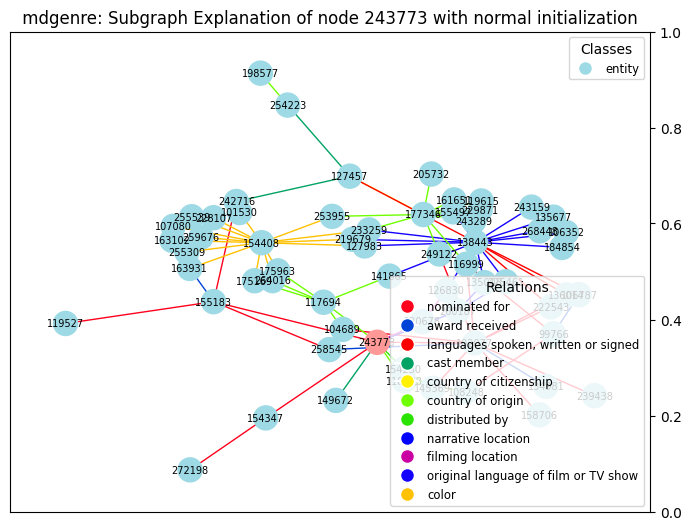

TypeError: cannot unpack non-iterable NoneType object

In [91]:
init = 'normal'
path = f'chk/{name}_chk/exp/init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/masked_adj'
#path = 'chk/mutag_chk/bro/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
node_idx = 243773
v = torch.load(f'{path}/masked_ver_thresh{node_idx}')
h = torch.load(f'{path}/masked_hor_thresh{node_idx}')
print(v.coalesce().values().count_nonzero())
h_t, v_t,t,t = threshold_mask(h,v,data,15)
#h_t, v_t = convert_binary(h), convert_binary(v)

edges, weights = visualize(node_idx, data,init,  v_t,h_t,result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False,make_connected=True)

In [93]:
data.i2e[243773]

('http://www.wikidata.org/entity/Q696057', 'iri')

In [54]:
import requests
from bs4 import BeautifulSoup

def get_wikidata_main_title(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        main_title = soup.find("span", {"class": "wikibase-title-label"}).text.strip()
        return main_title
    else:
        print(f"Failed to retrieve data from {url}")
        return None


main_title = get_wikidata_main_title(data.i2r[9])
print(main_title)


signature


tensor(47)
tensor(516)


StopIteration: 

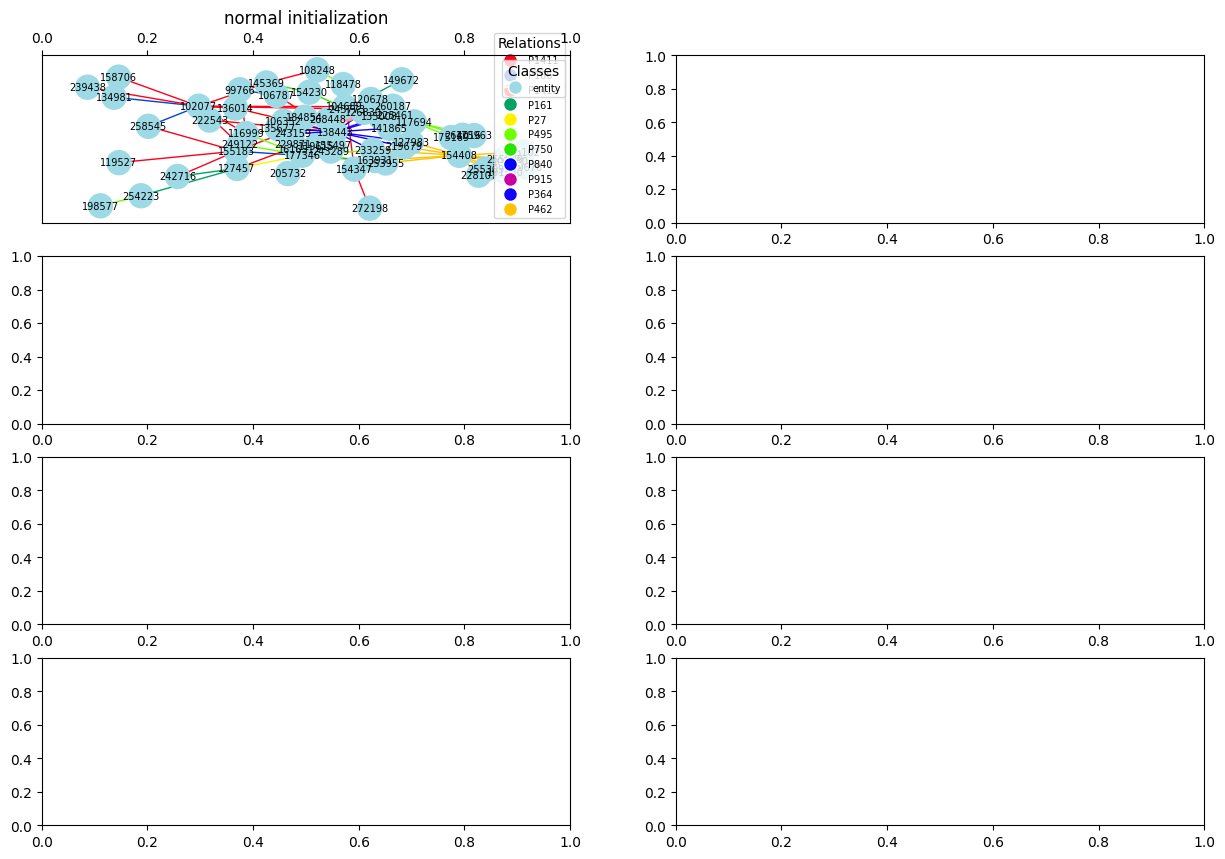

In [40]:
sampled_nodes = [8081,8318]
node_idx = 243773
visualize_all_inits(node_idx,data)

In [8]:
int(data.withheld[torch.where(data.withheld[:, 0] == torch.tensor([node_idx])),1])

3

In [453]:
triples = []
for i,j in zip(edges, weights):
    triples.append([data.i2e[i[0]][0], data.i2r[j], data.i2e[i[1]][0]])
triples

[['http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1067instance',
  'http://swrc.ontoware.org/ontology#author',
  'http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id12instance'],
 ['http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1067instance',
  'http://swrc.ontoware.org/ontology#author',
  'http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2039instance'],
 ['http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id12instance',
  'http://swrc.ontoware.org/ontology#author',
  'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id369instance'],
 ['http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id12instance',
  'http://swrc.ontoware.org/ontology#member',
  'http://www.aifb.uni-karlsruhe.de/Projekte/viewProjektOWL/id31instance'],
 ['http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id12instance',
  'http://swrc.ontoware.org/ontology#publication',
  'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPub

In [18]:
def visualize_new(node_idx,data,init, masked_ver,masked_hor, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True,make_connected=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    name = data.name
    n_hop = 2
    threshold = 0.5

    if selected_visualization:
        sel_masked_ver, sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold),sub_sparse_tensor(masked_ver, threshold,data, low_threshold)

    else:
        sel_masked_ver, sel_masked_hor = masked_ver, masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    
    G = nx.Graph()
    if result_weights: #the edge value is the mask weight       
        G.add_edges_from([(int(s), int(o), {'weight': np.round(p, 2)}) for s, p, o in zip(indices_nodes[0], sel_masked_ver.coalesce().values().tolist(), indices_nodes[1])])

    else: #the edge value is the relation
        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        G.add_edges_from([(int(s), int(o), {'weight': p}) for s, p, o in find_repeating_sublists(triples_matched.tolist())])

    if connected_subgraph:
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [list(set([item] if not isinstance(item, list) else item)) for item in weights]

    ordered_dict = {}
    for node in G.nodes:
        node_value = str(data.i2e[int(node)])
        node_label = extract_node_label(node_value)
        ordered_dict[int(node)] = node_label
        


    dict_node_color = {k: data.entities_classes[v] if v in data.entities_classes else 0 for k, v in ordered_dict.items()} 
    dict_node_color[node_idx] = 7
    labeldict = {int(node): int(node) for node in G.nodes}
    pos = nx.circular_layout(G)

    
    if make_connected:
        disconnected_triples = [[i[0], j[0], i[1]] for i, j in zip(edges, weights)] + [[i[0], j[1], i[1]] for i, j in zip(edges, weights) if len(j) > 1]; guideline_triples = data.triples.tolist()
        G = connect_minimally(disconnected_triples, guideline_triples)
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
        labeldict = {int(node): int(node) for node in G.nodes}
        if name == 'dbo_gender' :
            labeldict = {int(node): str(data.i2e[int(node)]).split('/')[-1].split(',')[0] for node in G.nodes}

            
        rel = {k: [v] for k, v in nx.get_edge_attributes(G, 'weight').items()}
        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in rel.items()}

        pos = nx.spring_layout(G,seed=42)
            
        min_x = min(pos[node][0] for node in pos)
        max_x = max(pos[node][0] for node in pos)
        shift = (max_x - min_x) * 0.05  # Adjust the value 0.05 to control the shift amount
        for node in pos:
            if pos[node][0] == max_x:
                pos[node] = (pos[node][0] - shift, pos[node][1])

        col_weights = [weights[i] for i in range(len(weights))]

        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}
        legend_elements = []
       
        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        edge_color=[label_colors[data.i2rel[i][0]] for i in col_weights]
        return G, pos, labeldict, edges, node_colors, edge_color,legend_elements, legend_elements1
        
    if result_weights==False and make_connected==False:
        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]

        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in {k: list(set(v)) for k, v in nx.get_edge_attributes(G, 'weight').items()}.items()}
        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}

        legend_elements = []

        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        edge_color = [label_colors[data.i2rel[i][0]] for i in col_weights]


        return G, pos, labeldict, edges, node_colors, edge_color,legend_elements, legend_elements1

from matplotlib.font_manager import FontProperties


def visualize_all_inits(node_idx,data):
    inits = ['normal', 'overall_frequency', 'relative_frequency', 'inverse_relative_frequency', 'domain_frequency', 'range_frequency', 'Domain_Knowledge_backward', 'Domain_Knowledge_forward']

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))

    for init, ax in zip(inits, axes.flatten()):
        path = f'chk/{data.name}_chk/exp/init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/masked_adj'
        v = torch.load(f'{path}/masked_ver_thresh{node_idx}')
        h = torch.load(f'{path}/masked_hor_thresh{node_idx}')
        print(v.coalesce().values().count_nonzero())
        h_t, v_t,t,t = threshold_mask(h,v,data,15)
        G, pos, labeldict, edges, node_colors, edge_color, legend_elements, legend_elements1 = visualize_new(node_idx, data, init, v_t, h_t, result_weights=False, low_threshold=False, experiment_name=None, selected_visualization=True, connected_subgraph=False, make_connected=True)

        nx.draw(G, pos, labels=labeldict, edgelist=edges, node_color=node_colors, font_size=7, arrows=True, edge_color=edge_color, ax=ax)

        ax.legend(handles=legend_elements, loc='lower right', title='Relations', fontsize=7)
        ax_twiny = ax.twiny()  # Create a new axes sharing the y-axis with the original one
        ax_twiny.legend(handles=legend_elements1, title='Classes', loc='upper right', fontsize=7)
        label = int(data.withheld[torch.where(data.withheld[:, 0] == torch.tensor([node_idx])),1].long())
        ax.set_title(f"{init} initialization")

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.suptitle(f"{data.name} class {label}: {node_idx}",fontproperties=FontProperties(weight='bold'))
    plt.subplots_adjust(top=0.9)
    # Show the plots
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'chk/dbo_gender_chk/exp/init_normal_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/masked_adj/masked_ver_thresh8081'

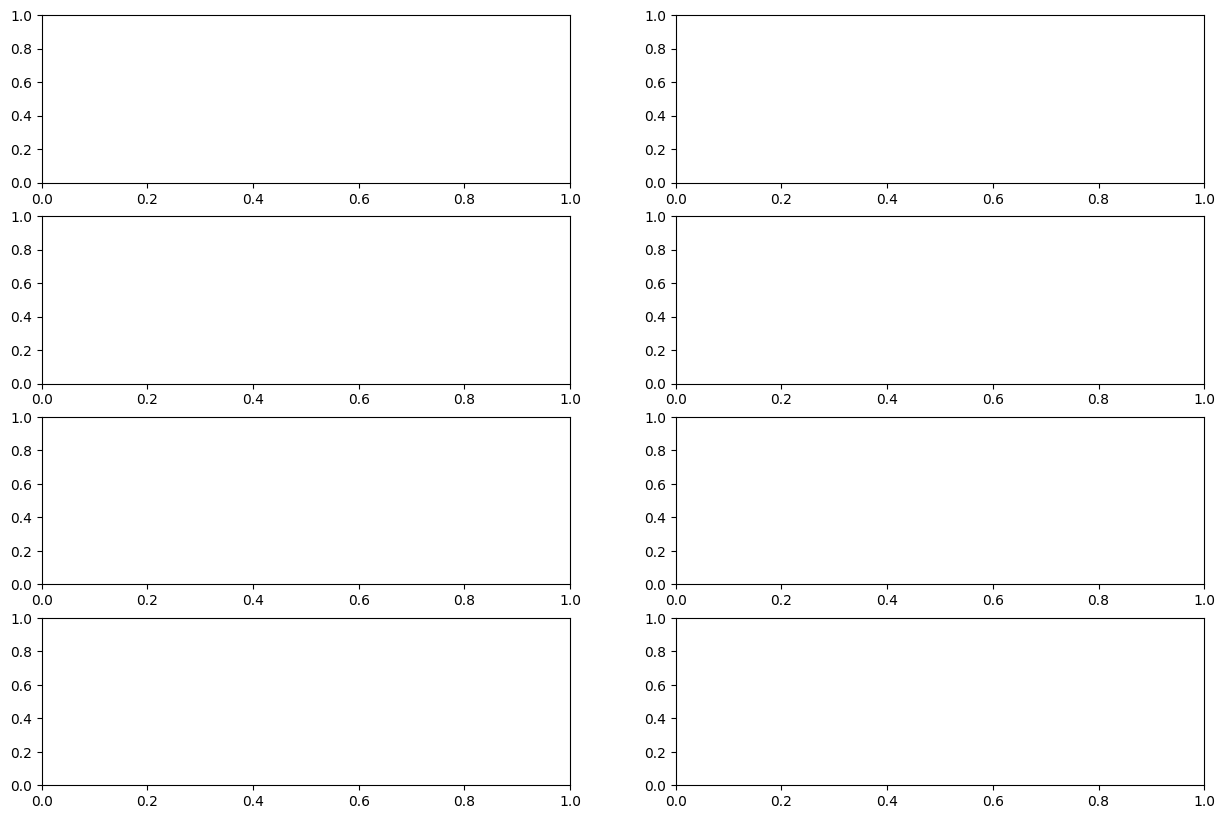

In [34]:
if name == 'dbo_gender':
    sampled_nodes = [8081,8318]
for node_idx in sampled_nodes:
    visualize_all_inits(node_idx,data)

tensor(15)
tensor(15)


StopIteration: 

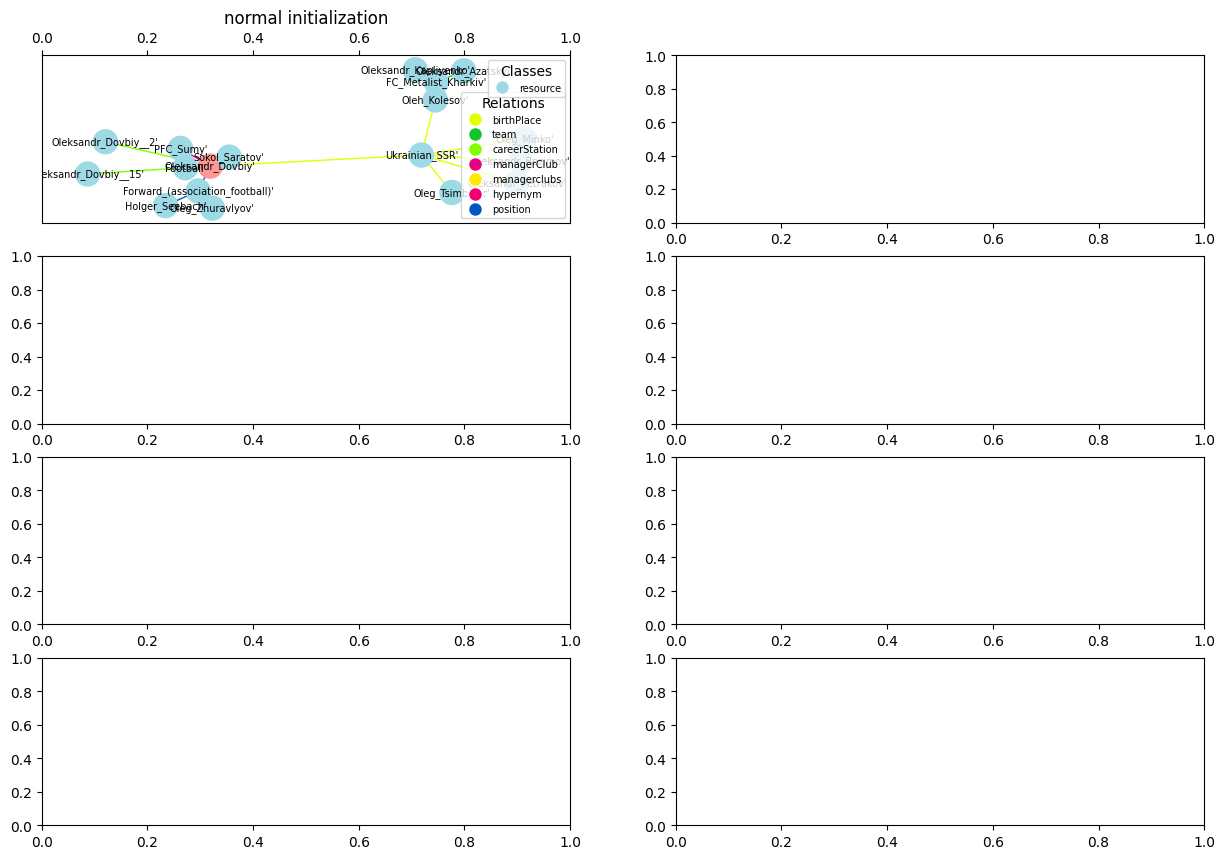

In [14]:
import random
random.seed(42)
sampled_nodes = []
for key in dict_classes:
    sampled_nodes.extend(random.sample(dict_classes[key], 1))
for node_idx in sampled_nodes:
    visualize_all_inits(node_idx,data)

In [ ]:

from matplotlib import legend
from networkx import spring_layout




def connect_minimally(disconnected_triples, guideline_triples):
    G = nx.Graph()
    G.add_edges_from([(int(u), int(v), {'weight': label}) for u, label, v in disconnected_triples])
    
    is_connected = nx.is_connected(G)
    
    if not is_connected:
        disconnected_nodes = {u for u, _, _ in disconnected_triples} | {v for _, _, v in disconnected_triples}
        subgraph = nx.Graph([(int(u), int(v), {'weight': label}) for u, label, v in guideline_triples if int(u) in disconnected_nodes and int(v) in disconnected_nodes])
        min_spanning_tree = nx.minimum_spanning_tree(subgraph)
        G.add_edges_from(min_spanning_tree.edges(data=True))
    
    return G

def extract_node_label(node_value):
    if 'http' in node_value:
        split_result = node_value.split('/')
        if len(split_result) >= 4:
            if '#' in node_value:
                return split_result[3].split('#')[0]
            else:
                return split_result[3]
    return 'blank'


def get_wikidata_main_title(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        main_title = soup.find("span", {"class": "wikibase-title-label"}).text.strip()
        return main_title
    else:
        pass

def visualize(node_idx,data,init, masked_ver,masked_hor, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True,make_connected=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    name = data.name
    n_hop = 2
    threshold = 0.5

    if selected_visualization:
        sel_masked_ver, sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold),sub_sparse_tensor(masked_ver, threshold,data, low_threshold)

    else:
        sel_masked_ver, sel_masked_hor = masked_ver, masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    
    G = nx.Graph()
    if result_weights: #the edge value is the mask weight       
        G.add_edges_from([(int(s), int(o), {'weight': np.round(p, 2)}) for s, p, o in zip(indices_nodes[0], sel_masked_ver.coalesce().values().tolist(), indices_nodes[1])])

    else: #the edge value is the relation
        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        G.add_edges_from([(int(s), int(o), {'weight': p}) for s, p, o in find_repeating_sublists(triples_matched.tolist())])

    if connected_subgraph:
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [list(set([item] if not isinstance(item, list) else item)) for item in weights]

    ordered_dict = {}
    for node in G.nodes:
        node_value = str(data.i2e[int(node)])
        node_label = extract_node_label(node_value)
        ordered_dict[int(node)] = node_label
        


    dict_node_color = {k: data.entities_classes[v] if v in data.entities_classes else 0 for k, v in ordered_dict.items()} 
    dict_node_color[node_idx] = 7
    labeldict = {int(node): int(node) for node in G.nodes}
    pos = nx.circular_layout(G)

    
    if make_connected:
        disconnected_triples = [[i[0], j[0], i[1]] for i, j in zip(edges, weights)] + [[i[0], j[1], i[1]] for i, j in zip(edges, weights) if len(j) > 1]; guideline_triples = data.triples.tolist()
        G = connect_minimally(disconnected_triples, guideline_triples)
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
        labeldict = {int(node): int(node) for node in G.nodes}
        if name == 'dbo_gender' :
            labeldict = {int(node): str(data.i2e[int(node)]).split('/')[-1].split(',')[0] for node in G.nodes}

        rel = {k: [v] for k, v in nx.get_edge_attributes(G, 'weight').items()}
        # if name == 'mdgenre':
        #     rel = {k: [get_wikidata_main_title(data.i2rel[item][1]) for item in v] if isinstance(v, list) else get_wikidata_main_title(data.i2rel[v][1]) for k, v in rel.items()}

        # else:
            
        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in rel.items()}

        pos = nx.spring_layout(G,seed=55)
            
        min_x = min(pos[node][0] for node in pos)
        max_x = max(pos[node][0] for node in pos)
        shift = (max_x - min_x) * 0.05  # Adjust the value 0.05 to control the shift amount
        for node in pos:
            if pos[node][0] == max_x:
                pos[node] = (pos[node][0] - shift, pos[node][1])

        col_weights = [weights[i] for i in range(len(weights))]

        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        
        if name == 'mdgenre':
            label_colors = {get_wikidata_main_title(data.i2rel[i][1]): j for i,j in zip(col_weights,colors)}
        else:
            label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}
        legend_elements = []
       
        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        if name == 'mdgenre':
            edge_colors = [get_wikidata_main_title(data.i2rel[i][1]) for i in col_weights]
        else:
            edge_colors = [label_colors[data.i2rel[i][0]] for i in col_weights]
        nx.draw(G, pos,labels = labeldict, edgelist=edges,node_color = node_colors  ,font_size=7, arrows = True,edge_color=edge_colors)
        plt.legend(handles=legend_elements, loc='lower right',title= 'Relations',fontsize='small')
        ax = plt.gca().twinx()

        ax.legend(handles=legend_elements1,  title='Classes', loc='upper right',fontsize='small')

        plt.title(f" {data.name}: Subgraph Explanation of node {node_idx} with {init} initialization ")
        plt.show()
        
    if result_weights==False and make_connected==False:
        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]

        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in {k: list(set(v)) for k, v in nx.get_edge_attributes(G, 'weight').items()}.items()}
        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}

        legend_elements = []

        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        nx.draw(G, pos,labels = labeldict, edgelist=edges,node_color = node_colors  ,font_size=7, arrows = True,edge_color=[label_colors[data.i2rel[i][0]] for i in col_weights])
        plt.legend(handles=legend_elements, loc='lower right',title= 'Relations',fontsize='small')
        ax = plt.gca().twinx()

        ax.legend(handles=legend_elements1,  title='Classes', loc='upper right',fontsize='small')
        plt.title(f" {data.name}: Subgraph Explanation of node {node_idx} with {init} initialization ")


        plt.show()

    if result_weights:
        col_weights = [weights[i] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  [dict_node_color[i] for i in G.nodes], cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
        if not os.path.exists(f'chk/{name}_chk/exp/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/exp/{experiment_name}⁄graphs/Explanation_{node_idx}_weights.png')


    else:
        if not os.path.exists(f'chk/{name}_chk/exp/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/exp/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/exp/{experiment_name}⁄graphs/Explanation_{node_idx}_relations.png')    
        return  edges, weights



